In [4]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm
import matplotlib.colors as colors

import seaborn as sns
# sns.set_theme(style="whitegrid")

%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [5]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))
################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
# bins_logenergy = np.linspace(min_log_e, 5, 30+1)
bins_logenergy = np.linspace(min_log_e, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)



===== Setting up csky =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [6]:
df = pd.read_pickle(ANA_DIR+f"/unblind/result01.pkl")

In [7]:
-np.log10(9e-06)

5.045757490560675

In [8]:
df.iloc[1632].pre_p

9e-06

In [9]:
df_top5 = df[['grb_name',
 'ra',
 'dec',
 'source_uncertainty',
 'mjd_start',
 't100',
 'gbm',
 'pos_error_source',
 'fluence',
 'redshift',
 'hasHealpix',
 'tw',
 'ts',
 'ns',
 'post_p']].sort_values('post_p').head(5).copy()
df_top5

,grb_name,ra,dec,source_uncertainty,mjd_start,t100,gbm,pos_error_source,fluence,redshift,hasHealpix,tw,ts,ns,post_p
1632,GRB140807A,200.160000,26.490000,4.394479,56876.499692,0.000006,1,Fermi_GBM,1.286500e-06,NaN,True,100,19.469318,1.083586,0.000046
1075,GRB160804D,93.260000,-7.660000,9.065763,57604.967751,0.000002,1,Fermi_GBM,2.808000e-07,NaN,True,100,14.113972,2.808878,0.000961
1079,GRB160802A,28.029167,71.366667,0.441667,57602.259371,0.000209,0,IPN,6.839900e-05,NaN,True,50,11.205534,2.735372,0.001283
316,GRB190321A,315.700000,6.620000,3.572227,58563.362889,0.000646,1,Fermi_GBM,6.589900e-06,NaN,True,100,13.238818,1.795262,0.001333
748,GRB170915A,120.260000,-38.420000,2.710746,58011.160766,0.000181,1,Fermi_GBM,7.408500e-06,NaN,True,100,9.440196,1.778291,0.001823


In [10]:
class args:
    grb_name = "GRB140807A"
    source_name = "bn140807500"
    tw_in_second = 100.
    ncpu = 4
    
grb_row = df.loc[df['grb_name'] == args.grb_name]
tw = args.tw_in_second/86400.
tw_start = grb_row.t_center - 0.5*tw
ra = grb_row.ra
dec = grb_row.dec

conf = {
    'ana': ana,
    #### llh basics: csky.conf
    'space': 'ps', # ps/fitps/template/prior
    'time': 'transient', # utf/lc/transient
    'energy': 'customflux', # fit/customflux
    'flux': cy.hyp.PowerLawFlux(2.5),
    #### inj.py - prior has some duplications against space's prior
    'sig': 'transient', # ps/tw/lc/transient/template/prior
    'full_sky': True,
    'extended': True,
    'mp_cpus': args.ncpu,
    'cut_n_sigma': 3,
    
    'TRUTH': True
    }

cy.CONF.update(conf)

In [11]:
dict({'cmap':'viridis'})

{'cmap': 'viridis'}

In [33]:
tmp_style = {
    'text.usetex' : False,
    'mathtext.rm' : 'Times New Roman',
    'mathtext.it' : 'Times New Roman:italic',
    'mathtext.bf' : 'Times New Roman:bold',
    'mathtext.fontset': 'stix',
    'axes.titlesize' : 20,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 14,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.minor.size' : 3,
    'ytick.minor.size' : 3,
    'axes.labelsize' : 20,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.right' : True,
    'xtick.top' : True,
    'axes.grid' : True,
    'axes.grid.which' : 'major',
    'axes.linewidth': 1.5,
    'grid.color' : 'lightgrey',
    'grid.alpha' : 0.4,
    'grid.linewidth' : 0.75,
    'lines.linewidth' : 1.5,
    'font.size' : 16,
    'image.cmap': 'PuBu',
}

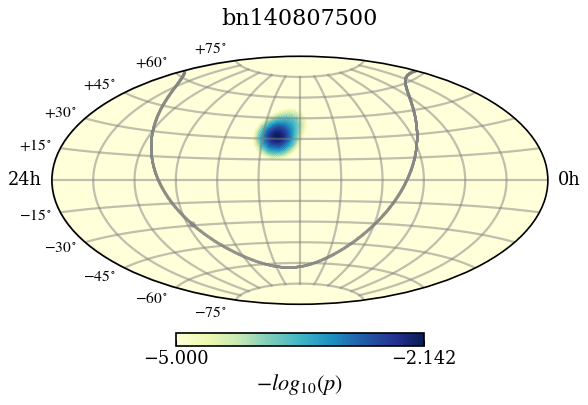

In [34]:
with mpl.rc_context(tmp_style):
    healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
    q=1
    healpix = np.maximum(healpix,0)
    ########## healpix reduce (< instead of <=) ##########
    healpix[healpix < isf_healpix(healpix, q=q)] = 0
    healpix = healpix / np.sum(healpix)

    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='YlGnBu'))
    mesh, cb = sp.plot_map(ax, np.log10(np.maximum(healpix, 1e-5)), n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    # cb.set_label(r'Spatial Prior (log scale)')
    cb.set_label(r'$-log_{10}(p)$')
    # ax.set_title(f"{args.source_name}, n_side=64, q={q}", fontsize=14, y=1.05)
    ax.set_title(f"{args.source_name}", y=1.1)
    # plt.tight_layout()
    plt.show()

In [35]:
# No prior sky scan
src = cy.utils.Sources(
    ra=ra,
    dec=dec,
    deg=True,
    mjd=tw_start, 
    sigma_t=np.zeros_like(tw), 
    t_100=tw,  # in days
    # prior=[hl.heal.HealHist(healpix)],
    name=args.grb_name
)
sstr = cy.get_sky_scan_trial_runner(conf=cy.CONF
                                    ,nside=64
                                    ,src_tr=src)

In [36]:
scan = sstr.get_one_scan(TRUTH=True
                         , mp_cpus=args.ncpu
                         , logging=True)

Scanning 49115 locations using 4 cores:
      49115/49115 coordinates complete.   


In [37]:
np.max(scan[1])

19.780306178198156

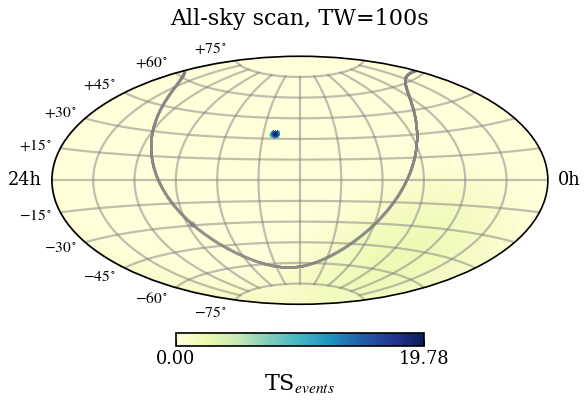

In [38]:
with mpl.rc_context(tmp_style):
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='YlGnBu'))
    mesh, cb = sp.plot_map(ax, scan[1], n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'TS$_{events}$')
    ax.set_title(f"All-sky scan, TW={int(args.tw_in_second)}s", y=1.1)
    # plt.tight_layout()
    plt.show()

In [39]:
# quick manual cross check
def getCombinedTS(healpix, scan):
    healpix = hl.heal.HealHist(healpix).map
    pt=healpix
    pt = np.where(healpix>0, healpix, 1e-10 * np.min(healpix[healpix>0]))
    pt = pt / np.sum(pt) / hp.nside2pixarea(64)
    pt = np.log(pt)
    pt = pt - np.max(pt)
    tss = scan.copy()
    # non-overlapping region will have negative TS anyways
    tss += 2. * pt
    tss[~np.isfinite(tss)] = 0
    tss[tss < 0] = 0
    return tss

np.max(getCombinedTS(healpix, scan[1]))

19.469319327258024

In [40]:
# Prior sky scan
src_prior = cy.utils.Sources(
    ra=ra,
    dec=dec,
    deg=True,
    mjd=tw_start, 
    sigma_t=np.zeros_like(tw), 
    t_100=tw,  # in days
    prior=[hl.heal.HealHist(healpix)],
    name=args.grb_name
)
sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
                                    ,nside=64
                                    ,src_tr=src_prior
                                    ,llh_priors=[healpix])

In [41]:
combined_scan = sptr.get_one_scan(TRUTH=True, mp_cpus=args.ncpu, logging=True)
np.max(combined_scan[0] + 2 * sptr.llh_prior_term[0])

Scanning 23447 locations using 4 cores:
      23447/23447 coordinates complete.   


19.469319327258024

In [46]:
# -logp, TS, ns, ra, dec
sptr.get_one_fit(TRUTH=True, mp_cpus=args.ncpu, logging=True)

Scanning 23447 locations using 4 cores:
      23447/23447 coordinates complete.   


array([19.46931933, 19.46931933,  1.08358651,  3.48520435,  0.58486081])

In [47]:
np.rad2deg([3.48520435,  0.58486081])

array([199.6875    ,  33.51005602])

In [49]:
10**-19.47

3.3884415613920344e-20

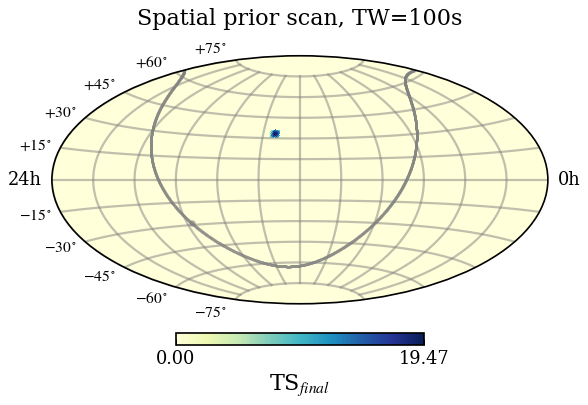

In [43]:
with mpl.rc_context(tmp_style):
    combined_ts = getCombinedTS(healpix, scan[1])
    fig, ax = plt.subplots (figsize=(8,6), dpi=80,
                            subplot_kw=dict (projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='YlGnBu'))
    mesh, cb = sp.plot_map(ax, np.maximum(0, combined_scan[0] + 2 * sptr.llh_prior_term[0]), n_ticks=2)
    kw = dict(color='.5', alpha=.5, linewidth=2)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    cb.set_label(r'TS$_{final}$')
    ax.set_title(f"Spatial prior scan, TW={int(args.tw_in_second)}s", y=1.1)
    # plt.tight_layout()
    plt.show()

In [20]:
evss = sptr.get_one_trial(TRUTH=True).evss[0][0]
evss_raw = ana[0].data[(ana[0].data.mjd >= np.float64(tw_start)) & (ana[0].data.mjd <= np.float64(tw_start + tw))]

In [21]:
evss_df = pd.DataFrame({
    'id': evss_raw.event,
    'ra': np.rad2deg(evss.ra),
    'dec': np.rad2deg(evss.dec),
    'sigma': np.rad2deg(evss.sigma),
    'energy': evss.energy,
    'pidLength': evss_raw.pidLength
})
evss_df

,id,ra,dec,sigma,energy,pidLength
0,6010596,76.838928,-51.471188,35.366028,49.746216,15.0
1,6194315,200.161102,33.337860,1.010449,221.285309,765.0


In [11]:
import numpy as np
gfu_evt = np.load("/storage/home/hhive1/cchen641/data/icecube/data/analyses/gfu/version-002-p06/IC86_2014_data.npy")
gfu_6194315 = gfu_evt[(gfu_evt['time']>56876.50013854-0.0001) & (gfu_evt['time']<56876.50013854+0.0001)]
gfu_6194315

array([(125146, 6194315, 0, 56876.50013854, 0.45744329, 2.15880919, 3.48387448, 0.58921949, 0.01181882, 2.83850519)],
      dtype=[('run', '<u4'), ('event', '<u4'), ('subevent', '<u4'), ('time', '<f8'), ('azi', '<f8'), ('zen', '<f8'), ('ra', '<f8'), ('dec', '<f8'), ('angErr', '<f8'), ('logE', '<f8')])

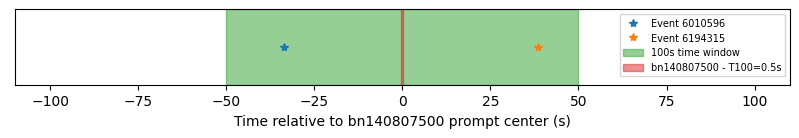

In [52]:
fig, ax = plt.subplots(figsize=(10, 1), dpi=100)
time_marks = np.array([56876.49930234-56876.499692, 56876.50013854-56876.499692]) * 86400
ax.plot(-33.66662362, 0, '*', color=sns.color_palette()[0], label="Event 6010596")
ax.plot(38.58105645, 0, '*', color=sns.color_palette()[1], label="Event 6194315")
ax.axvspan(-50., 50., 0, 1, alpha=0.5, color=sns.color_palette()[2], label="100s time window")
ax.axvspan(-0.25, 0.25, 0, 1, alpha=0.5, color=sns.color_palette()[3], label="bn140807500 - T100=0.5s")
ax.plot([-100,100], [0,0], alpha=0)
ax.set_yticks([])
ax.set_xlabel(r'Time relative to bn140807500 prompt center (s)')
ax.legend(fontsize=7)